In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json
import seaborn as sns
from scipy.stats import gaussian_kde

In [2]:
import monalysa
from monalysa import movements
from monalysa import quality

In [3]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight

In [4]:
base_fig_dir = pathlib.Path.cwd().parent / "figures"

## An Improved Peaks Metric for Assessing Movement Smoothness

In [5]:
n_moves = 1000
# Generate n_moves movements
movesdata = [movements.generate_random_movement(move_type='Gaussian')[:2]
             for _ in range(n_moves)]

# Add noise to the movement data
movesdatan = [_move[1] + 0.05 * np.random.randn(len(_move[1]))
              for _move in movesdata]

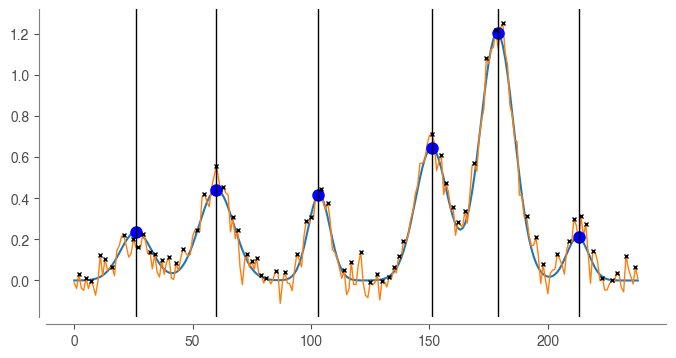

In [42]:
# Compute peaks.
inx = np.random.randint(1000)
_peaks = signal.find_peaks(movesdata[inx][1])
_peaksn = signal.find_peaks(movesdatan[inx])


fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(movesdata[inx][1])
ax.plot(movesdatan[inx], lw=1)
ax.plot(_peaks[0], movesdata[inx][1][_peaks[0]], 'o', color="blue", ms=8)
ax.plot(_peaksn[0], movesdatan[inx][_peaksn[0]], 'x', color="black", ms=3)
for _p in _peaks[0]:
    ax.axvline(_p, color='k', linestyle='solid', linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')

## A Bootstrap based method for peak detection

Steps:
0. Take the original signal and do a simple low-pass filter.
1. Repeat following steps N times.
2. Add random noise of some variance related to the signal power.
3. Find peaks and store them.

Plot the historgram of the peaks detected by the repeated noise addition and filtering. The modes of the histogram are where the peaks and valleys are.

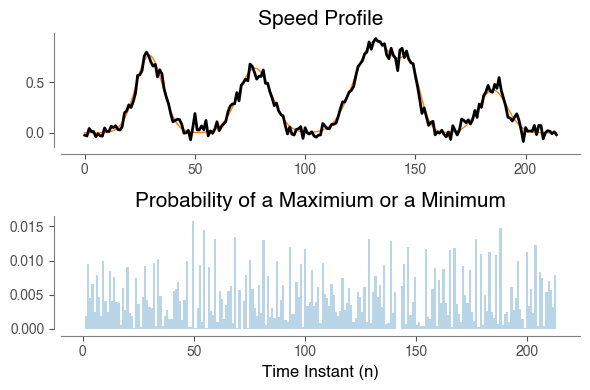

In [75]:
N_bs = 1000
sd_bs = 0.05

inx = np.random.randint(1000)
Nwin, pord = 1, 0
_movef = signal.savgol_filter(movesdatan[inx], window_length=Nwin,
                              polyorder=pord, mode="mirror")

_Nm = len(_movef)
_moves_bs = [signal.savgol_filter(_movef + sd_bs * np.random.randn(_Nm),
                                  window_length=Nwin, polyorder=pord,
                                  mode="mirror")
             for i in range(N_bs)]

# Find the peak for each boostraped movement.
_peaks_bs = [signal.find_peaks(_move)[0] for _move in _moves_bs]
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(movesdata[inx][1], color="tab:orange", lw=1)
ax.plot(_movef, lw=2, color="black")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
# ax.set_xlabel("Time Instant (n)", fontsize=12)
ax.set_title("Speed Profile", fontsize=15)
ax = fig.add_subplot(212)
ax.hist(np.hstack(_peaks_bs), bins=_Nm, density=True, alpha=0.3);
# Calculate the KDE
kde = gaussian_kde(np.hstack(_peaks_bs), bw_method=0.025)
# Generate x values for the plot
# x_vals = np.linspace(min(np.hstack(_peaks_bs)), max(np.hstack(_peaks_bs)), 100)
# Plot the KDE
# plt.plot(x_vals, kde(x_vals), color='black', lw=1)
# sns.histplot(np.hstack(_peaks_bs));
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time Instant (n)", fontsize=12)
ax.set_title("Probability of a Maximium or a Minimum", fontsize=15)

plt.tight_layout()

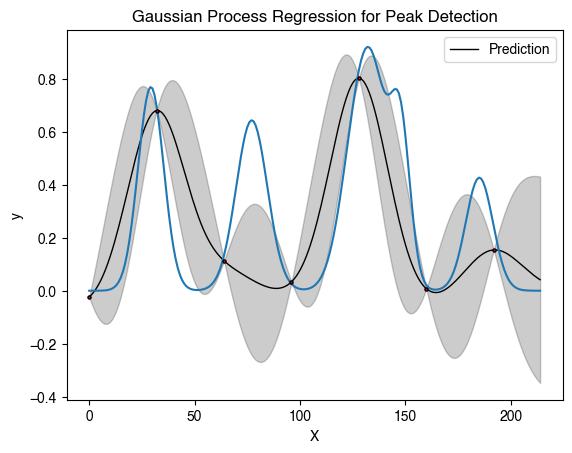

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Generate example data (replace with your actual data)
_X = np.arange(_Nm).reshape(-1, 1)
_y = _movef

# Down sample
Ns = 32
X = _X[::Ns, :]
y = _y[::Ns]

# Choose and define a kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# Train the Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, y)

# Make predictions and estimate uncertainty
X_new = _X
y_pred, sigma = gp.predict(X_new, return_std=True)

# Visualize the results
plt.scatter(X, y, c='r', s=5, zorder=10, edgecolors=(0, 0, 0))
plt.plot(X_new, y_pred, 'k-', alpha=1.0, lw=1, label='Prediction')
plt.plot(movesdata[inx][1], 'tab:blue')
plt.fill_between(X_new.ravel(), y_pred - sigma, y_pred + sigma, alpha=0.2, color='k')
plt.xlabel('X')
plt.ylabel('y')
# plt.xlim(0, 1)
plt.title('Gaussian Process Regression for Peak Detection')
plt.legend()
plt.show()


In [126]:
# Compute smoothness
# SPARC
sparc_smooth = np.array([
    [quality.smoothness.sparc(_move, fs=1 / tsamp)[0]
     for _move in _moves]
    for _moves in movedata
])
# SPARC
ldlj_smooth = np.array([
    [quality.smoothness.log_dimensionless_jerk(_move, fs=1 / tsamp, data_type="vel")
     for _move in _moves]
    for _moves in movedata
])

(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(105, 1)
(110, 1)
(115, 1)
(120, 1)
(125, 1)
(130, 1)
(135, 1)
(140, 1)
(145, 1)
(150, 1)
(155, 1)
(160, 1)
(165, 1)
(171, 1)
(175, 1)
(180, 1)
(185, 1)
(190, 1)
(195, 1)
(200, 1)
(205, 1)
(210, 1)
(216, 1)
(220, 1)
(225, 1)
(230, 1)
(235, 1)
(241, 1)
(245, 1)
(250, 1)
(255, 1)
(260, 1)
(266, 1)
(270, 1)
(275, 1)
(280, 1)
(285, 1)
(291, 1)
(295, 1)
(300, 1)
(305, 1)
(310, 1)
(315, 1)
(320, 1)
(325, 1)
(330, 1)
(335, 1)
(341, 1)
(345, 1)
(100, 1)
(110, 1)
(120, 1)
(130, 1)
(140, 1)
(150, 1)
(160, 1)
(171, 1)
(180, 1)
(190, 1)
(200, 1)
(

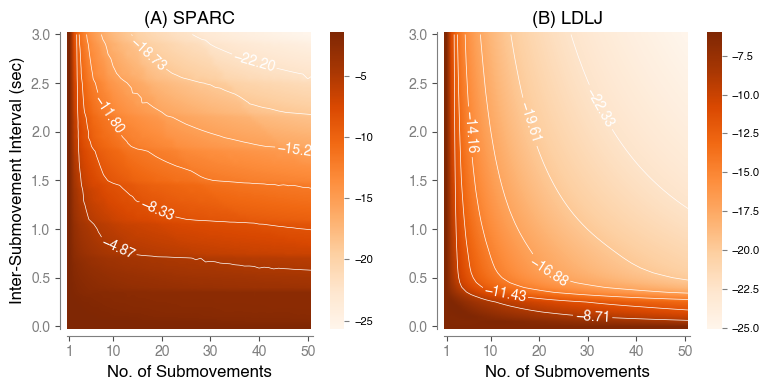

In [132]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(121)
_data = sparc_smooth[::-1, :]
_hm = ax.imshow(_data, cmap='Oranges', interpolation='bilinear')
levels = np.linspace(np.min(_data), np.max(_data), 8)
contours = ax.contour(Ns, np.arange(len(Ts)), _data, colors='white',
                      extend='both', levels=levels, linewidths=0.5,
                      linestyles='solid')
ax.clabel(contours, inline=True, fontsize=10)
_cbar = plt.colorbar(_hm)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=8)
_cbar.set_alpha(0.7)
_cbar.outline.set_linewidth(0.)
_cbar.ax.yaxis.set_tick_params(color='tab:gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("No. of Submovements", fontsize=12)
ax.set_ylabel("Inter-Submovement Interval (sec)", fontsize=12)
ax.set_xticks([0, 9, 19, 29, 39, 49],
              labels=[1, 10, 20, 30, 40, 50], color="tab:gray")
ax.set_yticks(np.arange(_data.shape[0])[::10],
              labels=3 - Ts[::10], color="tab:gray")
ax.set_yticks(np.arange(_data.shape[0])[::10],
              labels=3 - Ts[::10], color="tab:gray")
ax.set_title("(A) SPARC", fontsize=13)

ax = fig.add_subplot(122)
_data = ldlj_smooth[::-1, :]
_hm = ax.imshow(_data, cmap='Oranges', interpolation='bilinear')
        #   vmin=-20, vmax=-1)
levels = np.linspace(np.min(_data), np.max(_data), 8)
contours = ax.contour(Ns, np.arange(len(Ts)), _data, colors='white',
                      extend='both', levels=levels, linewidths=0.5,
                      linestyles='solid')
ax.clabel(contours, inline=True, fontsize=10)
_cbar = plt.colorbar(_hm)
_cbar.ax.tick_params(labelsize=8)
_cbar.set_alpha(0.7)
_cbar.outline.set_linewidth(0.)
_cbar.ax.yaxis.set_tick_params(color='tab:gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xticks([0, 9, 19, 29, 39, 49],
              labels=[1, 10, 20, 30, 40, 50], color="tab:gray")
ax.set_yticks(np.arange(_data.shape[0])[::10],
              labels=3 - Ts[::10], color="tab:gray")
ax.set_xlabel("No. of Submovements", fontsize=12)
ax.set_title("(B) LDLJ", fontsize=13)

plt.tight_layout()
plt.subplots_adjust(wspace=0.0)
plt.tight_layout()

# Save the figure
fig.savefig(pathlib.Path(base_fig_dir, f"smm_struct.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"smm_struct.svg"), bbox_inches="tight")